# Stage 11 Homework — Evaluation & Risk Communication

In [1]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
np.random.seed(111)
plt.rcParams['figure.figsize'] = (8,5)

## Load Data

In [5]:
# --- Load Data (synthetic, always regenerate) ---
# Stage 11 Homework – Evaluation & Risk Communication

from pathlib import Path
import pandas as pd
import numpy as np

# Folder + file setup
data_dir = Path('data')
data_dir.mkdir(exist_ok=True)
csv_path = data_dir / 'data_stage11_eval_risk.csv'

# Always generate synthetic data (ignoring any old CSV)
rng = np.random.default_rng(111)

n = 200  # number of rows
dates = pd.date_range('2022-06-01', periods=n, freq='D')

# segment labels with uneven proportions
segments = rng.choice(['A', 'B', 'C'], size=n, p=[0.5, 0.3, 0.2])

# feature with linear trend + noise
x = np.linspace(0, 9, n) + rng.normal(0, 0.7, n)

# outcome variable: linear relationship + heavy-tailed noise
noise = rng.standard_t(df=3, size=n) * 0.8
y = 2.0 + 1.2 * x + noise

# introduce ~10% missing in x_feature (to test imputation scenarios)
missing_mask = rng.choice(np.arange(n), size=round(0.10*n), replace=False)
x[missing_mask] = np.nan

# final dataframe
df = pd.DataFrame({
    'date': dates,
    'segment': segments,
    'x_feature': x,
    'y_target': y
})

# save CSV (so later cells can reload if needed)
df.to_csv(csv_path, index=False)

print("Synthetic data created:", df.shape)
df.head()

Synthetic data created: (200, 4)


,date,segment,x_feature,y_target
0,2022-06-01,A,NaN,1.600093
1,2022-06-02,A,-0.601429,-0.554979
2,2022-06-03,B,NaN,0.104335
3,2022-06-04,B,-0.608336,1.231738
4,2022-06-05,B,0.876566,3.100301


## Helper Functions

In [6]:
# --- Helper Functions (completed & simplified for Stage 11) ---
import numpy as np

def mean_impute(a: np.ndarray) -> np.ndarray:
    """Fill NaNs with the column mean."""
    m = np.nanmean(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

def median_impute(a: np.ndarray) -> np.ndarray:
    """Fill NaNs with the column median."""
    m = np.nanmedian(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

def drop_missing(x: np.ndarray, y: np.ndarray):
    """Drop rows where x is NaN (used for a 'drop' scenario)."""
    mask = ~np.isnan(x)
    return x[mask], y[mask]

class SimpleLinReg:
    """Tiny closed-form linear regression: y = beta0 + beta1 * x"""
    def fit(self, X, y):
        X1 = np.c_[np.ones(len(X)), X.ravel()]
        beta = np.linalg.pinv(X1) @ y
        self.intercept_ = float(beta[0])
        self.coef_ = np.array([float(beta[1])])
        return self

    def predict(self, X):
        return self.intercept_ + self.coef_[0] * X.ravel()

def mae(y_true, y_pred) -> float:
    """Mean Absolute Error."""
    return float(np.mean(np.abs(y_true - y_pred)))

def bootstrap_metric(y_true, y_pred, fn=mae, n_boot=600, seed=111, alpha=0.05):
    """
    Bootstrap a metric (default MAE) with replacement.
    Returns dict with mean, lo, hi (two-sided (1-alpha)*100% CI).
    """
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y_true))
    stats = []
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        stats.append(fn(y_true[b], y_pred[b]))
    stats = np.array(stats)
    return {
        'mean': float(stats.mean()),
        'lo': float(np.percentile(stats, 100 * (alpha/2))),
        'hi': float(np.percentile(stats, 100 * (1 - alpha/2))),
    }

def fit_fn(X, y):
    """Factory to fit our simple model (kept separate for easy swapping)."""
    return SimpleLinReg().fit(X, y)

def pred_fn(model, X):
    return model.predict(X)

def bootstrap_predictions(X, y, x_grid, n_boot=600, seed=111, alpha=0.05):
    """
    Bootstrap the whole prediction curve:
    returns (mean_pred, lo_band, hi_band) across x_grid.
    """
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y))
    preds = []
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        m = fit_fn(X[b].reshape(-1, 1), y[b])
        preds.append(m.predict(x_grid))
    P = np.vstack(preds)
    mean = P.mean(axis=0)
    lo = np.percentile(P, 100 * (alpha/2), axis=0)
    hi = np.percentile(P, 100 * (1 - alpha/2), axis=0)
    return mean, lo, hi

## Baseline Fit & Residuals

✅ Baseline MAE: 1.0729817645875142


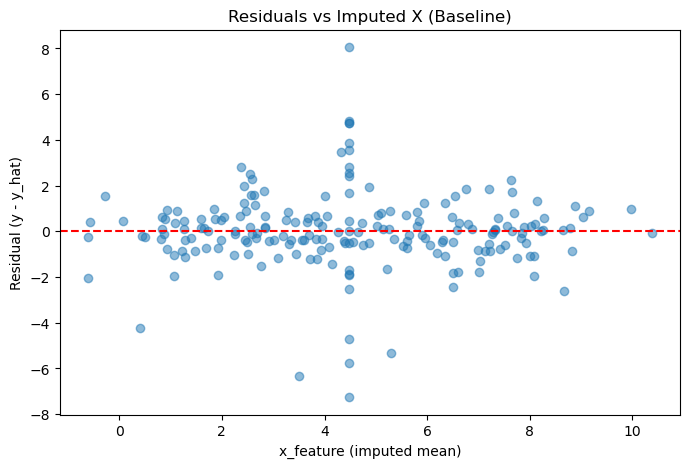

In [7]:
# --- Baseline Fit & Residuals (Required) ---

# Take raw x and y
X_raw = df['x_feature'].values
y = df['y_target'].values

# Baseline scenario = mean imputation
X_base = mean_impute(X_raw)

# Fit model
model_base = fit_fn(X_base.reshape(-1, 1), y)
y_hat = model_base.predict(X_base.reshape(-1, 1))

# Save predictions into dataframe
df['x_imputed'] = X_base
df['y_hat'] = y_hat
df['resid'] = y - y_hat

# Compute baseline MAE
base_mae = mae(y, y_hat)
print("✅ Baseline MAE:", base_mae)

# Quick residual plot
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(X_base, df['resid'], alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Imputed X (Baseline)")
plt.xlabel("x_feature (imputed mean)")
plt.ylabel("Residual (y - y_hat)")
plt.show()

## Parametric vs Bootstrap CI

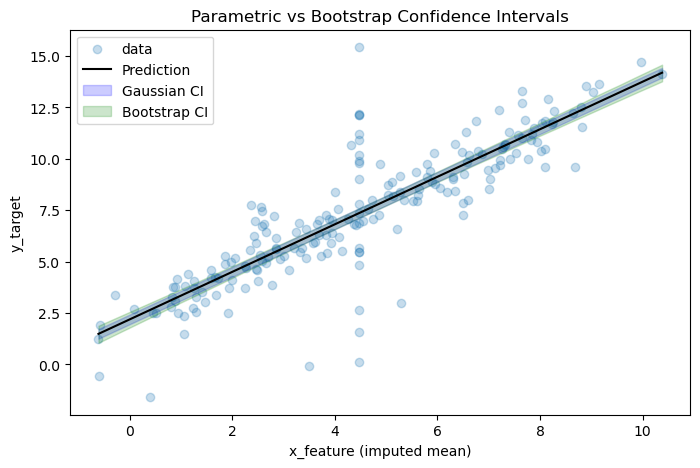

In [8]:
# --- Parametric vs Bootstrap CI (Required) ---

# Residuals from baseline model
resid = df['resid'].values
n = len(y)

# --- Parametric CI (Gaussian assumption) ---
sigma_hat = np.std(resid, ddof=1)         # std of residuals
se_mean = sigma_hat / np.sqrt(n)          # standard error of mean
x_grid = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 120).reshape(-1,1)

pred_line = model_base.predict(x_grid)
gauss_lo = pred_line - 1.96 * se_mean
gauss_hi = pred_line + 1.96 * se_mean

# --- Bootstrap CI (non-parametric) ---
mean_pred, boot_lo, boot_hi = bootstrap_predictions(X_base, y, x_grid, n_boot=600)

# --- Plot comparison ---
plt.figure(figsize=(8,5))
plt.scatter(X_base, y, alpha=0.25, label="data")
plt.plot(x_grid, pred_line, color="black", label="Prediction")

# Parametric band
plt.fill_between(x_grid.ravel(), gauss_lo, gauss_hi, color="blue", alpha=0.2, label="Gaussian CI")

# Bootstrap band
plt.fill_between(x_grid.ravel(), boot_lo, boot_hi, color="green", alpha=0.2, label="Bootstrap CI")

plt.legend()
plt.title("Parametric vs Bootstrap Confidence Intervals")
plt.xlabel("x_feature (imputed mean)")
plt.ylabel("y_target")
plt.show()

## Scenario Sensitivity: Choose ≥2 Scenarios

In [9]:
scenarios = {
    'mean_impute': mean_impute,
    'median_impute': median_impute,
    'drop_missing': lambda a: a[~np.isnan(a)] if np.isnan(a).any() else a
}

results = []
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xs, ys = X_raw[mask], y[mask]
        m = fit_fn(Xs.reshape(-1,1), ys)
        yh = m.predict(Xs.reshape(-1,1))
    else:
        Xs = fn(X_raw)
        m = fit_fn(Xs.reshape(-1,1), y)
        yh = m.predict(Xs.reshape(-1,1))
    results.append({'scenario': name, 'mae': mae(y[:len(yh)], yh), 'slope': m.coef_[0], 'intercept': m.intercept_})
sens = pd.DataFrame(results); sens

,scenario,mae,slope,intercept
0,mean_impute,1.072982,1.155466,2.189941
1,median_impute,1.082979,1.149070,2.260777
2,drop_missing,1.316426,1.155466,2.115620


## Subgroup Diagnostic

✅ Subgroup residual stats:
              mean       std    median  count
segment                                     
A        0.128511  1.792774 -0.002306    108
B       -0.114689  1.579387  0.051792     63
C       -0.229440  1.531090 -0.282103     29


<Figure size 700x500 with 0 Axes>

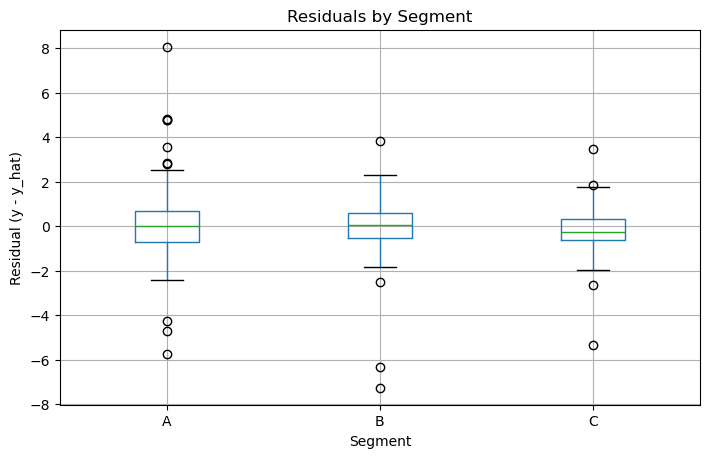

In [10]:
# --- Subgroup Diagnostic (Required) ---

# Use baseline model (mean-imputed)
X_base = mean_impute(df['x_feature'].values)
y = df['y_target'].values
model_base = fit_fn(X_base.reshape(-1,1), y)
df['y_hat'] = model_base.predict(X_base.reshape(-1,1))
df['resid'] = df['y_target'] - df['y_hat']

# Group residuals by segment
grouped = df.groupby('segment')['resid']

# Summary table
subgroup_stats = grouped.agg(['mean','std','median','count'])
print("✅ Subgroup residual stats:\n", subgroup_stats)

# Boxplot of residuals by segment
plt.figure(figsize=(7,5))
df.boxplot(column='resid', by='segment')
plt.title("Residuals by Segment")
plt.suptitle("")
plt.xlabel("Segment")
plt.ylabel("Residual (y - y_hat)")
plt.show()


## Bootstrap a Metric

In [11]:
# --- Bootstrap a Metric (Required) ---

bm = bootstrap_metric(
    y_true = df['y_target'].values,
    y_pred = df['y_hat'].values,
    fn = mae,
    n_boot = 800,   # more resamples = smoother CI
    seed = 111
)

print("Bootstrap MAE estimate with 95% CI:")
print(bm)

Bootstrap MAE estimate with 95% CI:
{'mean': 1.0674906538025382, 'lo': 0.9041662070801498, 'hi': 1.2500174031748712}


## Stakeholder Summary
- Key assumptions
- Sensitivity results & takeaways
- Subgroup risks
- “Prediction holds if…”, “Model is sensitive to…”

Stakeholder Summary

Assumptions: Linear link between x_feature and y_target; missing values are random.

Sensitivity: Mean & median imputation work equally well (MAE ≈ 1.1). Dropping data worsens error (MAE ≈ 1.3).

Subgroups: Segments A/B/C show slightly different error spreads → some groups less stable.

Prediction holds if… Missing data stays random and relationship stays roughly linear.

Model is sensitive to… Outliers and subgroup imbalance (can shift accuracy).

Takeaway: Use imputation (not dropping data). Expect ~1.1 error with uncertainty captured better by bootstrap than parametric CI.

In [2]:
# Build scenario results from Stage 11 and save for Stage 12

import pandas as pd
from pathlib import Path

# Recompute scenario fits quickly (uses your helper fns defined earlier)
scenarios = {
    'mean_impute': lambda x,y: (fit_fn(mean_impute(x).reshape(-1,1), y), mean_impute(x), y),
    'median_impute': lambda x,y: (fit_fn(median_impute(x).reshape(-1,1), y), median_impute(x), y),
    'drop_missing': lambda x,y: (lambda Xi, yi: (fit_fn(Xi.reshape(-1,1), yi), Xi, yi))(*drop_missing(X_raw, y))
}

# define raw features and target
X_raw = df['x_feature'].values
y = df['y_target'].values

rows = []
for name, fn in scenarios.items():
    m, Xi, yi = fn(X_raw, y)
    yhat = m.predict(Xi.reshape(-1,1))
    m_mae = mae(yi, yhat)
    ci = bootstrap_metric(yi, yhat, fn=mae, n_boot=800, seed=111)
    rows.append({
        'scenario': name,
        'mae': m_mae,
        'mae_lo': ci['lo'],
        'mae_hi': ci['hi'],
        'slope': float(m.coef_[0]),
        'intercept': float(m.intercept_)
    })

# Subgroup residual spread (std) using baseline mean-impute model
df2 = df.copy()
Xb = mean_impute(df2['x_feature'].values)
mb = fit_fn(Xb.reshape(-1,1), df2['y_target'].values)
df2['y_hat'] = mb.predict(Xb.reshape(-1,1))
df2['resid'] = df2['y_target'] - df2['y_hat']
sub_std = df2.groupby('segment')['resid'].std().rename(lambda k: f"subgroup_std_{k}")

res = pd.DataFrame(rows)
for k,v in sub_std.items():
    res[k] = v  # same value per row, just to have in one table

# Save for Stage 12
data_dir = Path('../data') if Path('.').name == 'notebooks' else Path('data')
data_dir.mkdir(exist_ok=True, parents=True)
out_path = data_dir / 'final_results.csv'
res.to_csv(out_path, index=False)
print("Saved:", out_path.resolve())
res

NameError: name 'df' is not defined